# Action Recognition

This notebook contains the main code for the action recognition task. It loads the participant data, preprocesses it and uses this data to train the different models. If one changes the participant, the best MLP models might also change, and thus the code must be adapted in this particular part.

### Import librairies

In [21]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

# Reproducibility
seed_num = RANDOM_STATE # This seed will be used for all random number generators
torch.use_deterministic_algorithms(True) # PyTorch will use deterministic algorithms fro operations with stochastic behavior like dropout
random.seed(seed_num) # Python's random will use seed_num
np.random.seed(seed_num) # NumPy's random number generator will use seed_num
torch.manual_seed(seed_num) # PyTorch's random number will use seed_num
def seed_worker(worker_id): # Seed synchronized on all parallel works
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator() # Creates an instance of PyTorch's random number generator
g.manual_seed(seed_num) # Set PyTorch generator g to seed_num

### Data loading

Change here the participant to load.

In [22]:
part_name = 's6'
use_saved = True

In [23]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [24]:
test_size = 0.3
pca_expl_var = 0.95

<span style='color: red'>WARNING</span>: computing all features takes around 9 minutes (Intel Core i7-7700K)

In [25]:
if use_saved and os.path.exists(f'saved/features_{part_name}_ExObs.h5'):
    features = pd.read_hdf(f'saved/features_{part_name}_ExObs.h5', 'df')
else:
    features = participant.get_features_all_sessions_ExObs()
    features.to_hdf(f'saved/features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

In [26]:
print(f'The dataset contains {features.shape[0]} samples and {features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_both)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_both]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 256 samples and 2881 features.
The 40 relevant channels are located in the following locations:
{'postcentral': 9, 'precentral': 13, 'WM_precentral': 5, 'caudalmiddlefrontal': 4, 'insula': 3, 'paracentral': 1, 'superiorfrontal': 5}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [27]:
use_saved = True

In [28]:
if use_saved and os.path.exists(f'saved/baseline_features_{part_name}_ExObs.h5'):
    baseline_features = pd.read_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df')
else:
    baseline_features = participant.get_features_all_sessions_unresponsive(movtype=None)
    baseline_features.to_hdf(f'saved/baseline_features_{part_name}_ExObs.h5', 'df', mode='w', data_columns=True)

In [29]:
print(f'The baseline dataset contains {baseline_features.shape[0]} samples and {baseline_features.shape[1]} features.')

The baseline dataset contains 256 samples and 2737 features.


In [30]:
accuracies = {}
accuracies_baseline = {}

### Possible hyperparameters for MLP models.

In [31]:
models = {
    '8_8_01': {
        'layers': (8, 8),
        'lr': 0.1
    },
    '8_16_01': {
        'layers': (8, 16),
        'lr': 0.1
    },
    '16_16_01': {
        'layers': (16, 16),
        'lr': 0.1
    },
    '32_16_01': {
        'layers': (32, 16),
        'lr': 0.1
    }, # more complex, might require higher learning rate
    '32_16_01': {
        'layers': (32, 16),
        'lr': 0.2
    }
}

### Train a model on the baseline features (Logistic Regression)

In [32]:
X = baseline_features.drop('label', axis=1)
y = baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['LR'] = accuracy

Accuracy: 0.68


#### With PCA

In [33]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['LR PCA'] = accuracy

Accuracy: 0.61


### Train a model (SVM)

In [34]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM'] = accuracy

Accuracy: 0.65


#### With PCA

In [35]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['SVM PCA'] = accuracy

Accuracy: 0.66


### Train a model (Random Forest)

In [36]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_baseline['RF'] = accuracy

Accuracy: 0.66


### Train a model (Multi-Layer Perceptron)

In [37]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False, num_workers=4)

    trainer = Trainer(mlp, params['lr'], 10, 4, save_path=f'saved/mlpARbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

print(valid_losses)
for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 45/45 [00:08<00:00,  5.09it/s]


Epoch: 1 	Training Loss: 0.749128 	Training Acc: 0.547486


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch: 1 	Validation Loss: 0.696014 	Validation Acc: 0.473684


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.90it/s]


Epoch: 2 	Training Loss: 0.697011 	Training Acc: 0.469274


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Epoch: 2 	Validation Loss: 0.692767 	Validation Acc: 0.526316


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.31it/s]


Epoch: 3 	Training Loss: 0.694167 	Training Acc: 0.480447


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch: 3 	Validation Loss: 0.691784 	Validation Acc: 0.526316


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.43it/s]


Epoch: 4 	Training Loss: 0.694962 	Training Acc: 0.418994


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Epoch: 4 	Validation Loss: 0.694216 	Validation Acc: 0.473684


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.26it/s]


Epoch: 5 	Training Loss: 0.694375 	Training Acc: 0.508380


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Epoch: 5 	Validation Loss: 0.699064 	Validation Acc: 0.473684


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.00it/s]


Epoch: 6 	Training Loss: 0.696611 	Training Acc: 0.491620


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Epoch: 6 	Validation Loss: 0.693548 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.33it/s]


Epoch: 7 	Training Loss: 0.691412 	Training Acc: 0.525140


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Epoch: 7 	Validation Loss: 0.693754 	Validation Acc: 0.473684


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.47it/s]


Epoch: 8 	Training Loss: 0.695891 	Training Acc: 0.458101


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Epoch: 8 	Validation Loss: 0.691976 	Validation Acc: 0.526316


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.98it/s]


Epoch: 9 	Training Loss: 0.695853 	Training Acc: 0.497207


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch: 9 	Validation Loss: 0.695709 	Validation Acc: 0.473684


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.27it/s]


Epoch: 10 	Training Loss: 0.694359 	Training Acc: 0.474860


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch: 10 	Validation Loss: 0.698228 	Validation Acc: 0.473684


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.64it/s]


Epoch: 1 	Training Loss: 0.798807 	Training Acc: 0.486034


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Epoch: 1 	Validation Loss: 0.692047 	Validation Acc: 0.526316


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.09it/s]


Epoch: 2 	Training Loss: 0.690312 	Training Acc: 0.530726


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Epoch: 2 	Validation Loss: 0.702831 	Validation Acc: 0.473684


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.00it/s]


Epoch: 3 	Training Loss: 0.695891 	Training Acc: 0.480447


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch: 3 	Validation Loss: 0.692272 	Validation Acc: 0.526316


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.54it/s]


Epoch: 4 	Training Loss: 0.697688 	Training Acc: 0.441341


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch: 4 	Validation Loss: 0.694900 	Validation Acc: 0.473684


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  8.62it/s]


Epoch: 5 	Training Loss: 0.695773 	Training Acc: 0.519553


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Epoch: 5 	Validation Loss: 0.695325 	Validation Acc: 0.473684


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:04<00:00, 10.54it/s]


Epoch: 6 	Training Loss: 0.692921 	Training Acc: 0.530726


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Epoch: 6 	Validation Loss: 0.698359 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  8.17it/s]


Epoch: 7 	Training Loss: 0.695340 	Training Acc: 0.486034


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch: 7 	Validation Loss: 0.693985 	Validation Acc: 0.473684


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.30it/s]


Epoch: 8 	Training Loss: 0.695519 	Training Acc: 0.458101


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Epoch: 8 	Validation Loss: 0.693426 	Validation Acc: 0.473684


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.23it/s]


Epoch: 9 	Training Loss: 0.695888 	Training Acc: 0.474860


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch: 9 	Validation Loss: 0.696763 	Validation Acc: 0.473684


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  7.74it/s]


Epoch: 10 	Training Loss: 0.695129 	Training Acc: 0.480447


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch: 10 	Validation Loss: 0.692155 	Validation Acc: 0.526316


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  8.32it/s]


Epoch: 1 	Training Loss: 0.806933 	Training Acc: 0.502793


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch: 1 	Validation Loss: 0.691866 	Validation Acc: 0.526316


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  8.72it/s]


Epoch: 2 	Training Loss: 0.692961 	Training Acc: 0.513966


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch: 2 	Validation Loss: 0.693996 	Validation Acc: 0.473684


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  8.58it/s]


Epoch: 3 	Training Loss: 0.695201 	Training Acc: 0.486034


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch: 3 	Validation Loss: 0.694224 	Validation Acc: 0.473684


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  8.50it/s]


Epoch: 4 	Training Loss: 0.697781 	Training Acc: 0.402235


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Epoch: 4 	Validation Loss: 0.692959 	Validation Acc: 0.526316


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:06<00:00,  7.44it/s]


Epoch: 5 	Training Loss: 0.695722 	Training Acc: 0.469274


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch: 5 	Validation Loss: 0.692143 	Validation Acc: 0.526316


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:04<00:00,  9.10it/s]


Epoch: 6 	Training Loss: 0.692640 	Training Acc: 0.508380


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Epoch: 6 	Validation Loss: 0.695393 	Validation Acc: 0.473684


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  8.70it/s]


Epoch: 7 	Training Loss: 0.696343 	Training Acc: 0.469274


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch: 7 	Validation Loss: 0.692176 	Validation Acc: 0.526316


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:08<00:00,  5.32it/s]


Epoch: 8 	Training Loss: 0.692427 	Training Acc: 0.513966


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch: 8 	Validation Loss: 0.691933 	Validation Acc: 0.526316


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  7.84it/s]


Epoch: 9 	Training Loss: 0.696706 	Training Acc: 0.458101


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch: 9 	Validation Loss: 0.692000 	Validation Acc: 0.526316


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  7.70it/s]


Epoch: 10 	Training Loss: 0.696058 	Training Acc: 0.497207


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch: 10 	Validation Loss: 0.693518 	Validation Acc: 0.473684


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  7.99it/s]


Epoch: 1 	Training Loss: 2.743181 	Training Acc: 0.502793


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch: 1 	Validation Loss: 0.695416 	Validation Acc: 0.473684


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:11<00:00,  3.87it/s]


Epoch: 2 	Training Loss: 0.694583 	Training Acc: 0.502793


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Epoch: 2 	Validation Loss: 0.691955 	Validation Acc: 0.526316


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:10<00:00,  4.48it/s]


Epoch: 3 	Training Loss: 0.693539 	Training Acc: 0.553073


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Epoch: 3 	Validation Loss: 0.697588 	Validation Acc: 0.473684


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:17<00:00,  2.57it/s]


Epoch: 4 	Training Loss: 0.699080 	Training Acc: 0.391061


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch: 4 	Validation Loss: 0.694719 	Validation Acc: 0.473684


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:07<00:00,  6.02it/s]


Epoch: 5 	Training Loss: 0.696966 	Training Acc: 0.458101


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch: 5 	Validation Loss: 0.692929 	Validation Acc: 0.526316


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:06<00:00,  7.46it/s]


Epoch: 6 	Training Loss: 0.694698 	Training Acc: 0.480447


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch: 6 	Validation Loss: 0.691958 	Validation Acc: 0.526316


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:06<00:00,  6.87it/s]


Epoch: 7 	Training Loss: 0.697850 	Training Acc: 0.452514


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch: 7 	Validation Loss: 0.692122 	Validation Acc: 0.526316


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:06<00:00,  7.42it/s]


Epoch: 8 	Training Loss: 0.697946 	Training Acc: 0.491620


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch: 8 	Validation Loss: 0.692157 	Validation Acc: 0.526316


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:05<00:00,  7.63it/s]


Epoch: 9 	Training Loss: 0.696186 	Training Acc: 0.452514


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch: 9 	Validation Loss: 0.695919 	Validation Acc: 0.473684


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:06<00:00,  7.21it/s]


Epoch: 10 	Training Loss: 0.693256 	Training Acc: 0.519553


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

Epoch: 10 	Validation Loss: 0.693080 	Validation Acc: 0.526316
{'8_8_01': 0.6982276376925016, '8_16_01': 0.6921553203934118, '16_16_01': 0.6935176755252638, '32_16_01': 0.6930802339001706}
Model 8_8_01 Validation Loss: 0.6982
Model 8_16_01 Validation Loss: 0.6922
Model 16_16_01 Validation Loss: 0.6935
Model 32_16_01 Validation Loss: 0.6931


For s6, the best model has a first layer of 8 neurons and a second layer of 16 neurons, with a learning rate of 0.1.

In [39]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_16_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpARbaseline_8_16_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_baseline['MLP'] = acc

Accuracy: 0.51


## Let's now do the analysis for the responsive channels

In [40]:
X = features.drop('label', axis=1)
y = features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [41]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['LR'] = accuracy

Accuracy: 0.99


#### With PCA

In [42]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['LR PCA'] = accuracy

Accuracy: 1.00


### Train a model (SVM)

In [43]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM'] = accuracy

Accuracy: 0.99


#### With PCA

In [44]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['SVM PCA'] = accuracy

Accuracy: 0.99


### Train a model (Random Forest)

In [45]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies['RF'] = accuracy

Accuracy: 0.99


### Train a model (Multi-Layer Perceptron)

In [46]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)
    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpAR_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 262.68it/s]


Epoch: 1 	Training Loss: 4.326697 	Training Acc: 0.793296


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.50it/s]


Epoch: 1 	Validation Loss: 0.533640 	Validation Acc: 0.868421


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 322.95it/s]


Epoch: 2 	Training Loss: 0.530776 	Training Acc: 0.843575


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.09it/s]


Epoch: 2 	Validation Loss: 0.336166 	Validation Acc: 0.868421


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 327.12it/s]


Epoch: 3 	Training Loss: 0.427700 	Training Acc: 0.821229


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.05it/s]


Epoch: 3 	Validation Loss: 0.401730 	Validation Acc: 0.868421


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 298.92it/s]


Epoch: 4 	Training Loss: 0.372883 	Training Acc: 0.837989


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1348.87it/s]


Epoch: 4 	Validation Loss: 0.355174 	Validation Acc: 0.868421


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 322.29it/s]


Epoch: 5 	Training Loss: 0.386584 	Training Acc: 0.832402


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.94it/s]


Epoch: 5 	Validation Loss: 0.348975 	Validation Acc: 0.868421


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 329.11it/s]


Epoch: 6 	Training Loss: 0.392256 	Training Acc: 0.832402


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.72it/s]


Epoch: 6 	Validation Loss: 0.348657 	Validation Acc: 0.868421


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 322.17it/s]


Epoch: 7 	Training Loss: 0.358512 	Training Acc: 0.854749


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.98it/s]


Epoch: 7 	Validation Loss: 0.217372 	Validation Acc: 0.947368


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 312.13it/s]


Epoch: 8 	Training Loss: 0.261406 	Training Acc: 0.905028


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.87it/s]


Epoch: 8 	Validation Loss: 0.069163 	Validation Acc: 1.000000


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 287.70it/s]


Epoch: 9 	Training Loss: 0.262814 	Training Acc: 0.910615


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1428.92it/s]


Epoch: 9 	Validation Loss: 0.076289 	Validation Acc: 1.000000


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 271.01it/s]


Epoch: 10 	Training Loss: 0.271443 	Training Acc: 0.910615


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.25it/s]


Epoch: 10 	Validation Loss: 0.060394 	Validation Acc: 1.000000


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 277.87it/s]


Epoch: 1 	Training Loss: 3.754922 	Training Acc: 0.826816


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.40it/s]


Epoch: 1 	Validation Loss: 6.265209 	Validation Acc: 0.842105


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 295.92it/s]


Epoch: 2 	Training Loss: 13.229758 	Training Acc: 0.921788


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.35it/s]


Epoch: 2 	Validation Loss: 1.990170 	Validation Acc: 0.894737


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 290.75it/s]


Epoch: 3 	Training Loss: 5.501303 	Training Acc: 0.955307


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1173.63it/s]


Epoch: 3 	Validation Loss: 0.742076 	Validation Acc: 0.947368


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 201.82it/s]


Epoch: 4 	Training Loss: 0.431381 	Training Acc: 0.966480


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1112.02it/s]


Epoch: 4 	Validation Loss: 0.724630 	Validation Acc: 0.947368


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 241.41it/s]


Epoch: 5 	Training Loss: 0.043126 	Training Acc: 0.972067


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.99it/s]


Epoch: 5 	Validation Loss: 0.676229 	Validation Acc: 0.947368


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 329.63it/s]


Epoch: 6 	Training Loss: 0.028738 	Training Acc: 0.988827


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.02it/s]


Epoch: 6 	Validation Loss: 0.609049 	Validation Acc: 0.947368


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 321.86it/s]


Epoch: 7 	Training Loss: 0.026724 	Training Acc: 0.988827


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1427.90it/s]


Epoch: 7 	Validation Loss: 0.529845 	Validation Acc: 0.947368


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 315.72it/s]


Epoch: 8 	Training Loss: 0.026166 	Training Acc: 0.988827


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1331.14it/s]


Epoch: 8 	Validation Loss: 0.463013 	Validation Acc: 0.947368


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 346.26it/s]


Epoch: 9 	Training Loss: 0.026888 	Training Acc: 0.988827


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.94it/s]


Epoch: 9 	Validation Loss: 0.408305 	Validation Acc: 0.947368


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 267.96it/s]


Epoch: 10 	Training Loss: 0.025856 	Training Acc: 0.988827


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.39it/s]

Epoch: 10 	Validation Loss: 0.361727 	Validation Acc: 0.947368



Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 239.96it/s]


Epoch: 1 	Training Loss: 24.187773 	Training Acc: 0.804469


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1110.72it/s]


Epoch: 1 	Validation Loss: 0.107394 	Validation Acc: 0.947368


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 245.32it/s]


Epoch: 2 	Training Loss: 0.083971 	Training Acc: 0.955307


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.07it/s]


Epoch: 2 	Validation Loss: 0.171003 	Validation Acc: 0.868421


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 248.54it/s]


Epoch: 3 	Training Loss: 0.062962 	Training Acc: 0.972067


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.25it/s]


Epoch: 3 	Validation Loss: 0.159892 	Validation Acc: 0.894737


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 266.19it/s]


Epoch: 4 	Training Loss: 0.031442 	Training Acc: 0.988827


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.31it/s]


Epoch: 4 	Validation Loss: 0.074848 	Validation Acc: 0.973684


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 172.15it/s]


Epoch: 5 	Training Loss: 0.018175 	Training Acc: 0.994413


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1250.31it/s]


Epoch: 5 	Validation Loss: 0.073094 	Validation Acc: 0.973684


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 219.47it/s]


Epoch: 6 	Training Loss: 0.015557 	Training Acc: 0.994413


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 999.62it/s]


Epoch: 6 	Validation Loss: 0.098961 	Validation Acc: 0.921053


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 191.60it/s]


Epoch: 7 	Training Loss: 0.014765 	Training Acc: 0.994413


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 907.96it/s]


Epoch: 7 	Validation Loss: 0.095575 	Validation Acc: 0.921053


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 197.94it/s]


Epoch: 8 	Training Loss: 0.015070 	Training Acc: 0.994413


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 666.65it/s]


Epoch: 8 	Validation Loss: 0.100404 	Validation Acc: 0.921053


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 230.52it/s]


Epoch: 9 	Training Loss: 0.015182 	Training Acc: 0.994413


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.79it/s]


Epoch: 9 	Validation Loss: 0.098196 	Validation Acc: 0.921053


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 216.29it/s]


Epoch: 10 	Training Loss: 0.014706 	Training Acc: 0.994413


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1120.96it/s]


Epoch: 10 	Validation Loss: 0.098377 	Validation Acc: 0.921053


Epoch 1/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 219.44it/s]


Epoch: 1 	Training Loss: 209.346343 	Training Acc: 0.776536


Epoch 1/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.55it/s]


Epoch: 1 	Validation Loss: 127.726950 	Validation Acc: 0.842105


Epoch 2/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 239.97it/s]


Epoch: 2 	Training Loss: 105.617423 	Training Acc: 0.905028


Epoch 2/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 798.63it/s]


Epoch: 2 	Validation Loss: 14.856399 	Validation Acc: 0.921053


Epoch 3/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 200.09it/s]


Epoch: 3 	Training Loss: 0.120548 	Training Acc: 0.910615


Epoch 3/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 908.92it/s]


Epoch: 3 	Validation Loss: 12.725871 	Validation Acc: 0.921053


Epoch 4/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 153.83it/s]


Epoch: 4 	Training Loss: 0.116096 	Training Acc: 0.938547


Epoch 4/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 588.20it/s]


Epoch: 4 	Validation Loss: 9.760490 	Validation Acc: 0.921053


Epoch 5/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 230.29it/s]


Epoch: 5 	Training Loss: 0.116859 	Training Acc: 0.938547


Epoch 5/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.49it/s]


Epoch: 5 	Validation Loss: 7.482034 	Validation Acc: 0.921053


Epoch 6/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 267.38it/s]


Epoch: 6 	Training Loss: 0.117087 	Training Acc: 0.938547


Epoch 6/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1110.99it/s]


Epoch: 6 	Validation Loss: 5.744799 	Validation Acc: 0.921053


Epoch 7/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 241.64it/s]


Epoch: 7 	Training Loss: 0.122288 	Training Acc: 0.938547


Epoch 7/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.13it/s]


Epoch: 7 	Validation Loss: 4.418145 	Validation Acc: 0.921053


Epoch 8/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 264.64it/s]


Epoch: 8 	Training Loss: 0.114778 	Training Acc: 0.910615


Epoch 8/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1249.46it/s]


Epoch: 8 	Validation Loss: 3.423479 	Validation Acc: 0.921053


Epoch 9/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 263.40it/s]


Epoch: 9 	Training Loss: 0.130001 	Training Acc: 0.938547


Epoch 9/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1110.46it/s]


Epoch: 9 	Validation Loss: 2.640827 	Validation Acc: 0.921053


Epoch 10/10 - Training: 100%|██████████| 45/45 [00:00<00:00, 267.37it/s]


Epoch: 10 	Training Loss: 0.123176 	Training Acc: 0.938547


Epoch 10/10 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1111.90it/s]


Epoch: 10 	Validation Loss: 2.045740 	Validation Acc: 0.921053
Model 8_8_01 Validation Loss: 0.0604
Model 8_16_01 Validation Loss: 0.3617
Model 16_16_01 Validation Loss: 0.0984
Model 32_16_01 Validation Loss: 2.0457


For participant s6, the best model has 2 layers of 8 neurons and a learning rate of 0.1. Contrary to the baseline, this version requires less complexity but achieve a much higher accuracy!

In [48]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpAR_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies['MLP'] = acc

Accuracy: 0.87


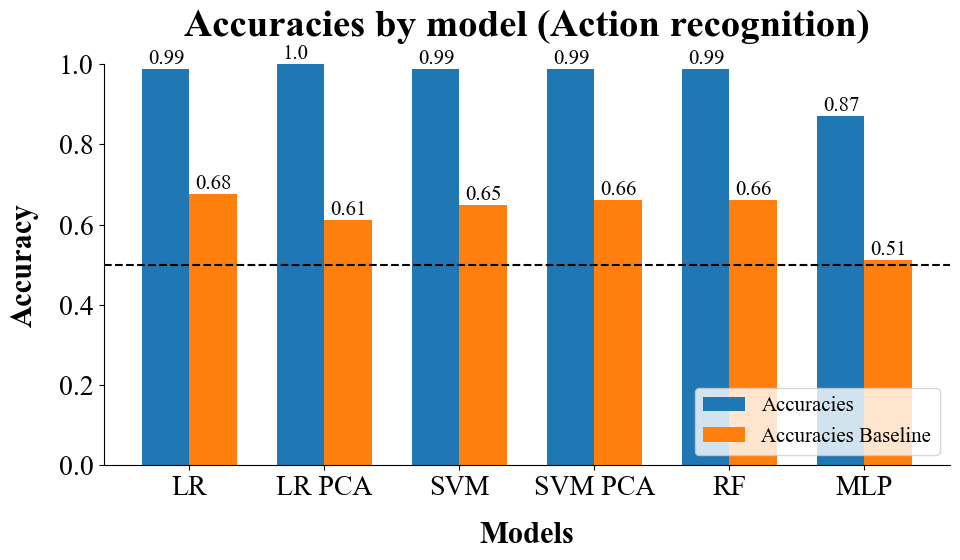

In [51]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies.keys()

dataset_values = [accuracies[model] for model in models]
baseline_values = [accuracies_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (Action recognition)')

ax.set_ylim(0,1)

ax.legend(loc = 'lower right')

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.axhline(0.5, linestyle='--', color='k')
plt.legend(loc='lower right', fontsize=15)

plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ExObs.png')
plt.show()